In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 1. Load the noisy image

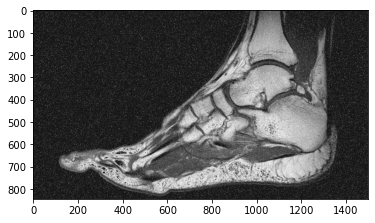

In [4]:
noisy_img = cv2.imread('noisy_img.png', 0)
plt.imshow(noisy_img, cmap='gray', vmin=0, vmax=255)

In [5]:
noisy_img.shape

(844, 1500)

### 2. Detect noise distribution type by cropping a proper part of the image

In [14]:
proper_pt = noisy_img[0:844, 0:110]

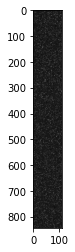

In [15]:
plt.imshow(proper_pt, cmap='gray', vmin=0, vmax=255)

#### Plot the histogram of the intensities.



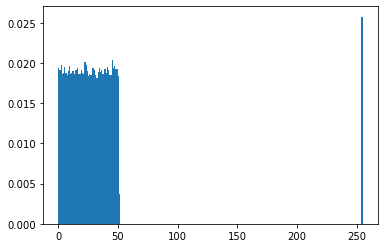

In [16]:
plt.hist(proper_pt.ravel(), density = True, bins=[i for i in range(proper_pt.min(), proper_pt.max() + 1)]);

#### TODO: What type is it???

### Implement Alpha-trimmed mean filter